In [5]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.nn.parameter import Parameter
from torch.distributions.multivariate_normal import  MultivariateNormal
from torch.autograd.functional import jacobian
from math import floor, ceil
from cmath import inf

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import os
import zipfile
import glob
import random
from PIL import Image
import seaborn as sns

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


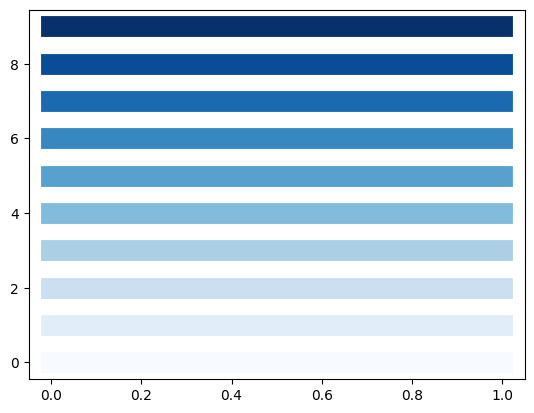

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def create_color_gradient(n):
    cmap = plt.get_cmap('Blues')  # Choose a colormap here
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    return colors

n = 10  # Number of steps in the gradient
colors = create_color_gradient(n)

# Display the colors
for i, color in enumerate(colors):
    plt.plot([0, 1], [i, i], color=color, linewidth=15)

plt.show()


/tmp/ipykernel_3950/1521623550.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


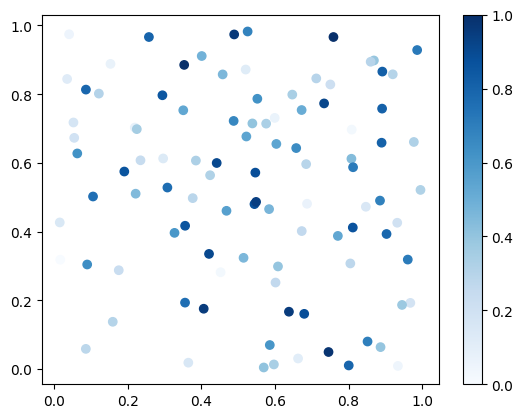

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable

# Create some data
x = np.random.random(100)
y = np.random.random(100)
c = np.random.random(100)  # This will be mapped to colors.

# Get the 'viridis' colormap
viridis = plt.get_cmap('Blues')

# Create a scatter plot with colors determined by c
plt.scatter(x, y, c=c, cmap=viridis)

# Create a mappable object
sm = ScalarMappable(cmap=viridis)
sm.set_array([])  # You have to set_array with empty list for the ScalarMappable.

# Add a colorbar
plt.colorbar(sm)

plt.show()


In [6]:
train_data = torchvision.datasets.MNIST('./data/', train=True, download=True)
train_data = train_data.data.to(torch.float32).reshape(len(train_data), -1)
train_data = torch.nn.functional.normalize(train_data, dim = 1)